In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import plotly.express as px

In [2]:
import warnings
warnings.filterwarnings('ignore')
import dvc.api


In [5]:
import numpy as np
import pandas as pd
import plots
import scipy.stats as scs
import random
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn import tree
import scipy.stats as stat
from helper import Helper
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier




In [6]:
CSV_PATH = "../Data/data.csv"

In [7]:
helper = Helper()

In [8]:
df = helper.read_csv(CSV_PATH)
df.head()

file read as csv


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [9]:
def get_data(tag, path='Data/clean_data.csv', repo='https://github.com/daniEL2371/abtest-mlops'):
    rev = tag
    data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
    df = pd.read_csv(data_url)
    return df

In [10]:

def drop_no_responds(df):
    cleaned_df = df.query("not (yes == 0 & no == 0)")
    return cleaned_df




In [11]:

def read_model(file_name):
    with open(f"../models/{file_name}.pkl", "rb") as f:
        return pickle.load(f)

def write_model(file_name, model):
    with open(f"../models/{file_name}.pkl", "wb") as f:
        pickle.dump(model, f)


### Data Transformation

In [12]:
cleaned_df = drop_no_responds(df)
cleaned_df['aware'] = cleaned_df['yes'].map(lambda x: x==1)
cleaned_df = cleaned_df.drop(columns = ['yes', 'no', 'auction_id'], axis=1)

In [13]:
def save_cleaned_data():
    CLEANED_CSV_PATH = "../Data/clean_data.csv"
    helper.save_csv(cleaned_df, CLEANED_CSV_PATH)

### Data preparation

##### Label Encoding

In [14]:
def encode_labels(df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    aware_encoder = preprocessing.LabelEncoder()
    
    df['date'] = date_encoder.fit_transform(df['date'])
    df['device_make'] = device_encoder.fit_transform(df['device_make'])
    df['browser'] = browser_encoder.fit_transform(df['browser'])
    df['experiment'] = experiment_encoder.fit_transform(cleaned_df['experiment'])
    df['browser'] = aware_encoder.fit_transform(df['browser'])
    df['aware'] = aware_encoder.fit_transform(df['aware'])


    
    return df
    
    

#### Spliting the data based on browser and platform_os

In [15]:

def feature_data(cleaned_df):
    
    broweser_df = cleaned_df[["experiment", "hour", "date", 'device_make', 'browser', 'aware']]
    platfrom_df = cleaned_df[["experiment", "hour", "date", 'device_make', 'platform_os', 'aware']]

    return broweser_df, platfrom_df


In [16]:

def save_encoded_df():
    
    broweser_df, platfrom_df = feature_data(encoded_df)
    helper.save_csv(broweser_df, "../Data/clean_data.csv")
    helper.save_csv(platfrom_df, "../Data/clean_data.csv")
    

### Model Building

#### Loss function

In [17]:
def loss_function(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    return rmse


#### Decision Tree Model

In [18]:
class DecisionTreesModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, max_depth=5):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.clf = DecisionTreeClassifier(max_depth=4)
        
    def train(self, folds=1):
        
        kf = KFold(n_splits = folds)
        
        iterator = kf.split(self.X_train)
        
        loss_arr = []
        acc_arr = []
        for i in range(folds):
            train_index, valid_index = next(iterator)
            
            X_train, y_train = self.X_train.iloc[train_index], self.y_train.iloc[train_index]
            X_valid, y_valid = self.X_train.iloc[valid_index], self.y_train.iloc[valid_index]
                        
            self.clf = self.clf.fit(X_train, y_train)
            
            vali_pred = self.clf.predict(X_valid)
            
            accuracy = self.calculate_score(y_valid
                                              , vali_pred)
            
            loss = loss_function(y_valid, vali_pred)
            
            self.__printAccuracy(accuracy, i, label="Validation")
            self.__printLoss(loss, i, label="Validation")
            print()
            
            acc_arr.append(accuracy)
            loss_arr.append(loss)

            
        return self.clf, acc_arr, loss_arr
    
    def test(self):
        
        y_pred = self.clf.predict(self.X_test)
        
        accuracy = self.calculate_score(y_pred, self.y_test)
        self.__printAccuracy(accuracy, label="Test")
        
        report = self.report(y_pred, self.y_test)
        matrix = self.confusion_matrix(y_pred, self.y_test)
        
        loss = loss_function(self.y_test, y_pred)
        
        return accuracy, loss,  report, matrix
    
    def get_feature_importance(self):
        importance = self.clf.feature_importances_
        fi_df = pd.DataFrame()
        
        fi_df['feature'] = self.X_train.columns.to_list()
        fi_df['feature_importances'] = importance
        
        return fi_df
    
    def __printAccuracy(self, acc, step=1, label=""):
        print(f"step {step}: {label} Accuracy of DecisionTreesModel is: {acc:.3f}")
    
    def __printLoss(self, loss, step=1, label=""):
        print(f"step {step}: {label} Loss of DecisionTreesModel is: {loss:.3f}")
    
    def calculate_score(self, pred, actual):
        return metrics.accuracy_score(actual, pred)
    
    def report(self, pred, actual):
        print("Test Metrics")
        print("================")
        print(metrics.classification_report(pred, actual))
        return metrics.classification_report(pred, actual)
    
    def confusion_matrix(self, pred, actual):
        ax=sns.heatmap(pd.DataFrame(metrics.confusion_matrix(pred, actual)))
        plt.title('Confusion matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        return metrics.confusion_matrix(pred, actual)


        
    
    
    


### Get our two versions of encoded dataframes from dvc

In [19]:
platform_df = get_data('enc-platform-df')
browser_df = get_data('enc-browser-df')


In [20]:

print("1. Encoded Dataframe containing the the platfrom column")
platform_df.head()


1. Encoded Dataframe containing the the platfrom column


,experiment,hour,date,device_make,platform_os,aware
0,1,2,2,4,6,0
1,1,16,1,13,6,1
2,1,8,3,13,6,0
3,0,4,5,43,6,1
4,0,15,0,13,6,0


In [21]:

print("2. Encoded Dataframe containing the the browser column")
browser_df.head()


2. Encoded Dataframe containing the the browser column


,experiment,hour,date,device_make,browser,aware
0,1,2,2,4,2,0
1,1,16,1,13,1,1
2,1,8,3,13,1,0
3,0,4,5,43,4,1
4,0,15,0,13,1,0


### 1 Model training using Decision Tree using browser dataframe

In [22]:
# import mlflow
# import datetime
# Current_Date = datetime.datetime.today()

# mlflow.set_experiment('ML_Approach_ABTEST-' + str(Current_Date))

#### Train Test Split

In [23]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

#### Model Training Using DecisionTreesModel

In [24]:

decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

folds = 5
clf, acc_arr, loss_arr = decisionTreesModel.train(folds)

write_model('browser_decision_tree_model', clf)

step 0: Validation Accuracy of DecisionTreesModel is: 0.571
step 0: Validation Loss of DecisionTreesModel is: 0.655

step 1: Validation Accuracy of DecisionTreesModel is: 0.531
step 1: Validation Loss of DecisionTreesModel is: 0.685

step 2: Validation Accuracy of DecisionTreesModel is: 0.558
step 2: Validation Loss of DecisionTreesModel is: 0.665

step 3: Validation Accuracy of DecisionTreesModel is: 0.516
step 3: Validation Loss of DecisionTreesModel is: 0.696

step 4: Validation Accuracy of DecisionTreesModel is: 0.565
step 4: Validation Loss of DecisionTreesModel is: 0.660



#### Evaluating our model

step 1: Test Accuracy of DecisionTreesModel is: 0.544
Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.53      0.69       116
           1       0.10      0.67      0.17         9

    accuracy                           0.54       125
   macro avg       0.53      0.60      0.43       125
weighted avg       0.89      0.54      0.65       125

Loss on test data is: 0.675
Test accuracy on test data is: 0.544



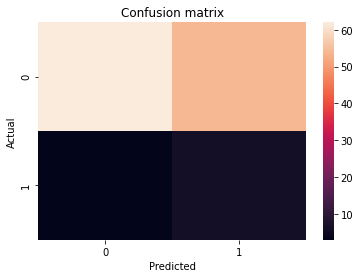

In [25]:

test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print(f"Test accuracy on test data is: {test_acc:.3f}")

print()


### Calculating feature importance

In [26]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.000000
1,hour,0.410528
2,date,0.054408
3,device_make,0.336032
4,browser,0.199031


Our experiment feature has feature importances of 0. This infers that 'experiment' feature is not the main driving feature of the Decision Tree Model. It is not contributing much for awareness. The most predictor for the Decision Tree Model is hour which with feature importance of 0.45 followed by device_make. But this is a result of a decision tree model with max-depth of 4. if we increase the max-depth, we might observe a differnt result in feature importance.

### Visualzing feature importance

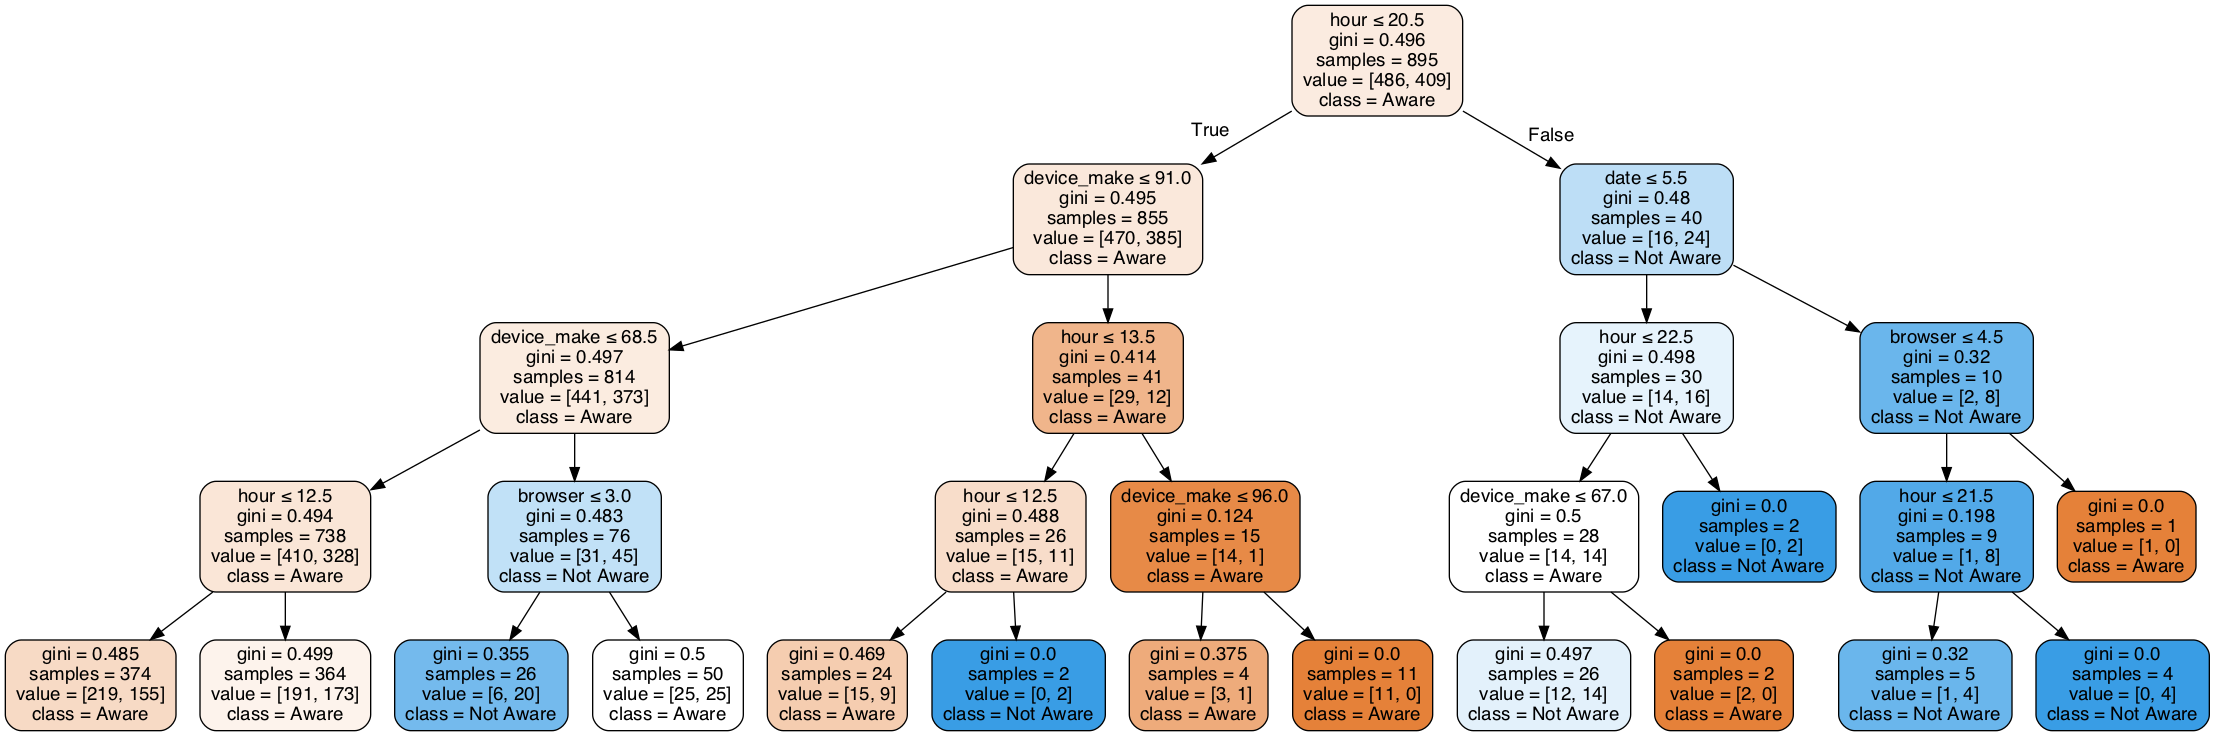

In [27]:
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')

Image(graph.create_png())


Our experiment feature is found on the 4th level depth of the Decision Tree. And it only divided leaves with '0' (Not Aware) out come. This infers that 'experiment' feature is not the main driving feature of the Decision Tree Model. It is not contributing much for awareness. The most predictor for the Decision Tree Model is hour which is the root node

### 1.2 Model training using Decision Tree using platform dataframe

In [29]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [30]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

folds = 5
clf, acc_arr, loss_arr = decisionTreesModel.train(folds)

write_model('platform_os_decision_tree_model', clf)

step 0: Validation Accuracy of DecisionTreesModel is: 0.554
step 0: Validation Loss of DecisionTreesModel is: 0.668

step 1: Validation Accuracy of DecisionTreesModel is: 0.527
step 1: Validation Loss of DecisionTreesModel is: 0.688

step 2: Validation Accuracy of DecisionTreesModel is: 0.554
step 2: Validation Loss of DecisionTreesModel is: 0.668

step 3: Validation Accuracy of DecisionTreesModel is: 0.502
step 3: Validation Loss of DecisionTreesModel is: 0.706

step 4: Validation Accuracy of DecisionTreesModel is: 0.543
step 4: Validation Loss of DecisionTreesModel is: 0.676



step 1: Test Accuracy of DecisionTreesModel is: 0.568
Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.55      0.70       113
           1       0.15      0.75      0.25        12

    accuracy                           0.57       125
   macro avg       0.55      0.65      0.47       125
weighted avg       0.88      0.57      0.65       125

Loss on test data is: 0.657



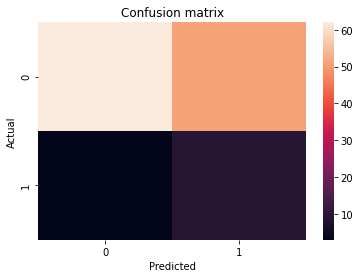

In [31]:
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [32]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.000000
1,hour,0.453469
2,date,0.176664
3,device_make,0.369866
4,platform_os,0.000000


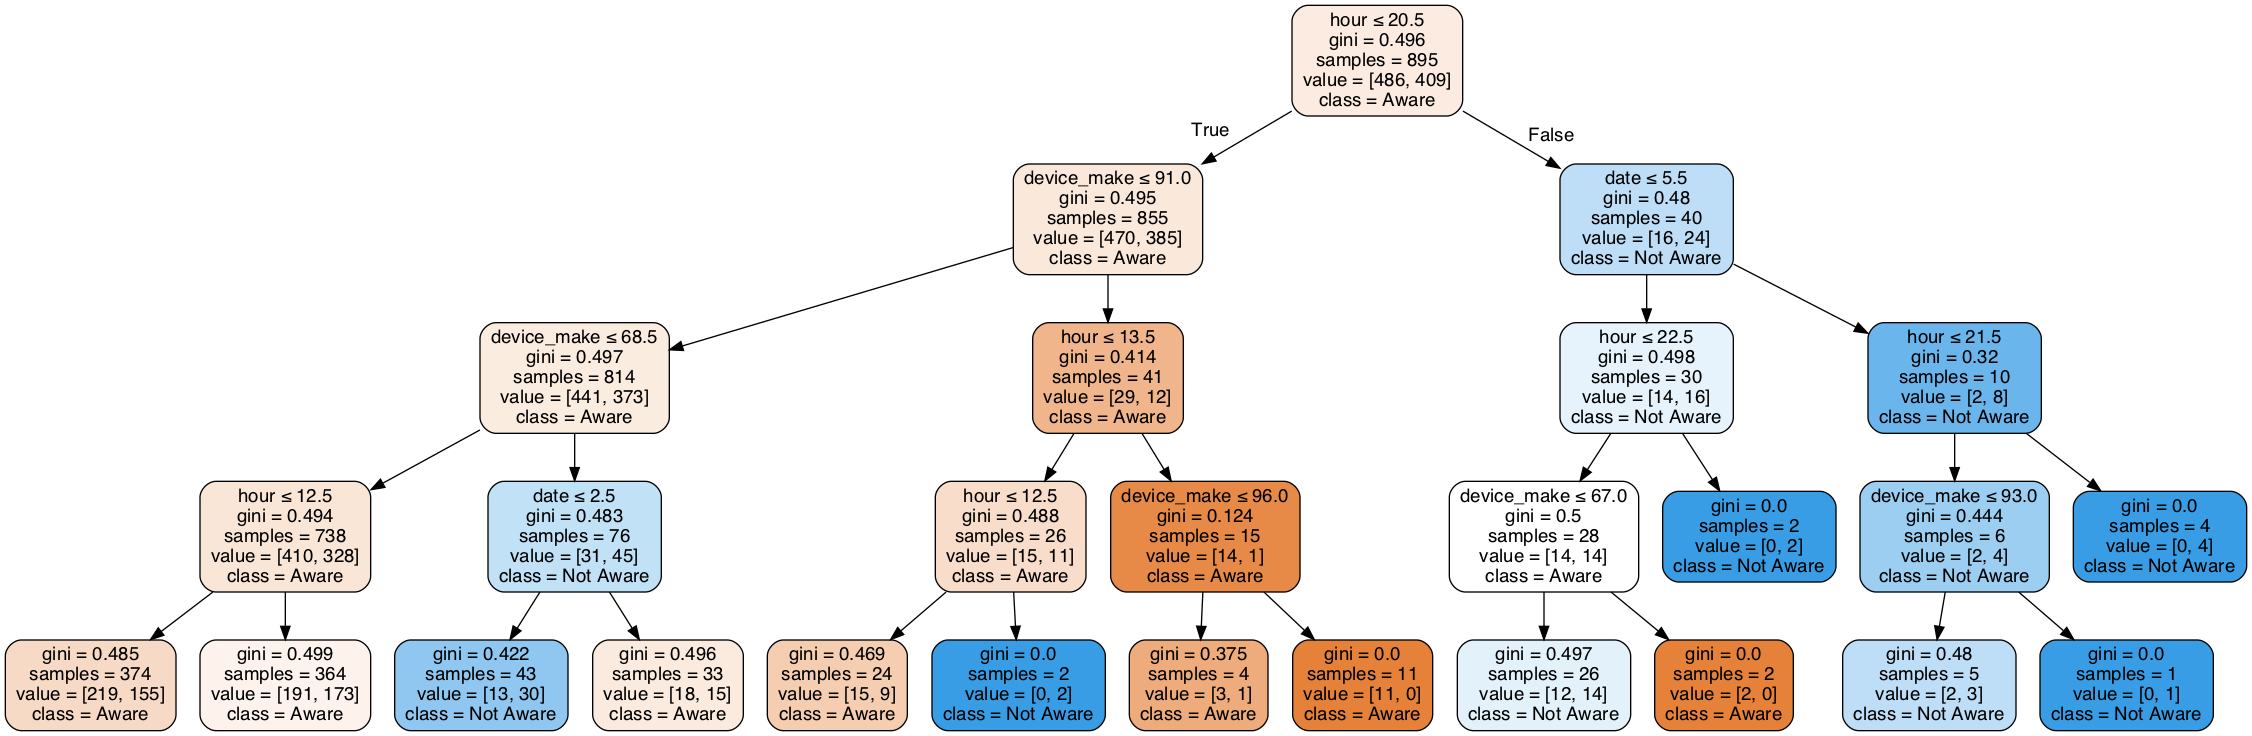

In [33]:
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')
Image(graph.create_png())



### Model Building using Logestic Regression

In [34]:
class LogesticRegressionModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, model_name="LR"):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model_name = model_name
        
        self.clf = LogisticRegression()
        
    def train(self, folds=1):
        
        kf = KFold(n_splits = folds)
        
        iterator = kf.split(self.X_train)
        
        loss_arr = []
        acc_arr = []
        model_name= self.model_name
#         mlflow.end_run()
        for i in range(folds):

            train_index, valid_index = next(iterator)

            X_train, y_train = self.X_train.iloc[train_index], self.y_train.iloc[train_index]
            X_valid, y_valid = self.X_train.iloc[valid_index], self.y_train.iloc[valid_index]

            self.clf = self.clf.fit(X_train, y_train)

            vali_pred = self.clf.predict(X_valid)

            accuracy = self.calculate_score(y_valid, vali_pred)
            loss = loss_function(y_valid, vali_pred)

            self.__printAccuracy(accuracy, i, label="Validation")
            self.__printLoss(loss, i, label="Validation")
            print()

            acc_arr.append(accuracy)
            loss_arr.append(loss)
            
        return self.clf, acc_arr, loss_arr
    
    def test(self):
        y_pred = self.clf.predict(self.X_test)
        
        accuracy = self.calculate_score(self.y_test, y_pred)
        self.__printAccuracy(accuracy, label="Test")
        
        report = self.report(y_pred, self.y_test)
        matrix = self.confusion_matrix(y_pred, self.y_test)
        loss = loss_function(self.y_test, y_pred)
        
        return accuracy, loss, report, matrix 
    
    def __printAccuracy(self, acc, step=1, label=""):
        print(f"step {step}: {label} Accuracy of LogesticRegression is: {acc:.3f}")
    
    def __printLoss(self, loss, step=1, label=""):
        print(f"step {step}: {label} Loss of LogesticRegression is: {loss:.3f}")
    
    def calculate_score(self, pred, actual):
        return metrics.accuracy_score(actual, pred)
    
    def report(self, pred, actual):
        print("Test Metrics")
        print("================")
        print(metrics.classification_report(pred, actual))
        return metrics.classification_report(pred, actual)
    
    def confusion_matrix(self, pred, actual):
        ax=sns.heatmap(pd.DataFrame(metrics.confusion_matrix(pred, actual)))
        plt.title('Confusion matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        return metrics.confusion_matrix(pred, actual)
    
    def get_p_values(self):
        """ 
        Calcualting p_values for logestic regression.
        code refered from the following link
        https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
        
        """
        denom = (2.0*(1.0+np.cosh(self.clf.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.clf.coef_[0]/sigma_estimates # z-score 
        p_values = [stat.norm.sf(abs(x)) for x in z_scores] ### two tailed test for p-values
        
        p_df = pd.DataFrame()
        p_df['features'] = self.X_train.columns.to_list()
        p_df['p_values'] = p_values
        
        return p_df
    
    def plot_pvalues(self, p_df):
        
        fig, ax = plt.subplots(figsize=(12,7))

        ax.plot([0.05,0.05], [0.05,5])
        sns.scatterplot(data=p_df, y='features', x='p_values', color="green")
        plt.title("P values of features", size=20)

        plt.xticks(np.arange(0,max(p_df['p_values']) + 0.05, 0.05))

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.show()
        return fig

        




        
    
    
  

In [35]:
# mlflow.end_run()
# with mlflow.start_run(run_name="Platform-DF-DecisionTree"):
#     mlflow.log_param('Features', X_train.columns.to_list())
#     mlflow.log_param('Target', y_train.columns.to_list())
#     mlflow.log_param('Number Of Training Dataset', X_train.shape[0])
#     mlflow.log_param('Number Of Test Dataset', X_test.shape[0])
#     mlflow.log_param('Fold number', folds)
    
#     mlflow.log_metric('Validation Accuray', acc_arr[-1])
#     mlflow.log_metric('Validation Loss', loss_arr[-1])
#     mlflow.log_metric('Test accuracy', test_acc)
#     mlflow.log_metric('Test Loss MSE', loss)
    
# #     mlflow.log_figure(graph.create_png(), 'fig.png')

### 2.1 Model training using Logestic Regression using browser dataframe

In [36]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [37]:
logesticRegressionModel = LogesticRegressionModel(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(folds)

write_model('browser_Logestic_Reg_model', clf2)


step 0: Validation Accuracy of LogesticRegression is: 0.545
step 0: Validation Loss of LogesticRegression is: 0.675

step 1: Validation Accuracy of LogesticRegression is: 0.527
step 1: Validation Loss of LogesticRegression is: 0.688

step 2: Validation Accuracy of LogesticRegression is: 0.554
step 2: Validation Loss of LogesticRegression is: 0.668

step 3: Validation Accuracy of LogesticRegression is: 0.543
step 3: Validation Loss of LogesticRegression is: 0.676

step 4: Validation Accuracy of LogesticRegression is: 0.574
step 4: Validation Loss of LogesticRegression is: 0.653



step 1: Test Accuracy of LogesticRegression is: 0.552
Test Metrics
              precision    recall  f1-score   support

           0       0.89      0.54      0.67       107
           1       0.18      0.61      0.28        18

    accuracy                           0.55       125
   macro avg       0.54      0.58      0.48       125
weighted avg       0.79      0.55      0.62       125



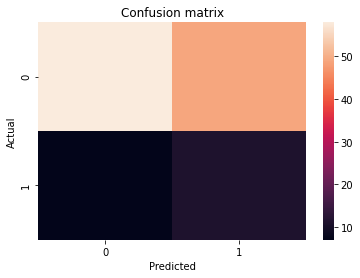

In [38]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()

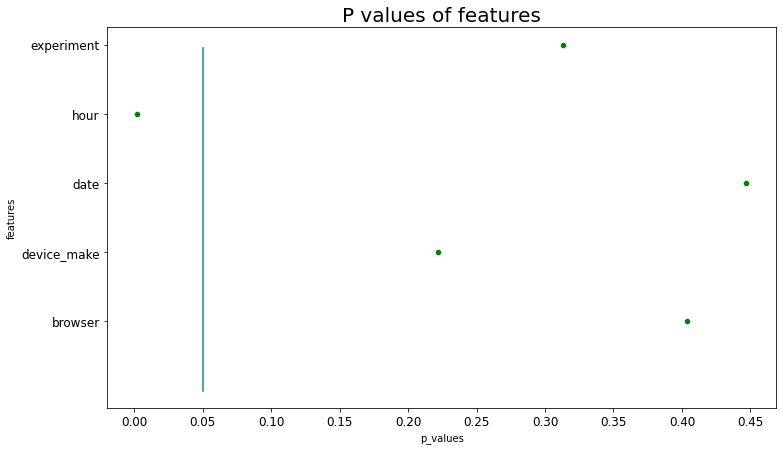

,features,p_values
0,experiment,0.313093
1,hour,0.002316
2,date,0.446756
3,device_make,0.221776
4,browser,0.403688


In [39]:

p_values_df = logesticRegressionModel.get_p_values()
p_value_fig = logesticRegressionModel.plot_pvalues(p_values_df)
p_values_df


The P-value for experiment is 0.3. It is not that much significant, since our significance level is 0.05. Hour is the most important predictor for the Logestic Regression Model with p value 0.001, it is then follwed by device_make then experiment. The least predictor for the Logestic Regression Model is date

### 2.2 Model training using Logestic Regression using platfrom dataframe


In [40]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [41]:
logesticRegressionModel = LogesticRegressionModel(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(folds)

write_model('platform_os_Logestic_Reg_model', clf2)


step 0: Validation Accuracy of LogesticRegression is: 0.518
step 0: Validation Loss of LogesticRegression is: 0.694

step 1: Validation Accuracy of LogesticRegression is: 0.500
step 1: Validation Loss of LogesticRegression is: 0.707

step 2: Validation Accuracy of LogesticRegression is: 0.558
step 2: Validation Loss of LogesticRegression is: 0.665

step 3: Validation Accuracy of LogesticRegression is: 0.534
step 3: Validation Loss of LogesticRegression is: 0.683

step 4: Validation Accuracy of LogesticRegression is: 0.552
step 4: Validation Loss of LogesticRegression is: 0.670



step 1: Test Accuracy of LogesticRegression is: 0.528
Test Metrics
              precision    recall  f1-score   support

           0       0.91      0.53      0.67       112
           1       0.12      0.54      0.19        13

    accuracy                           0.53       125
   macro avg       0.51      0.53      0.43       125
weighted avg       0.83      0.53      0.62       125



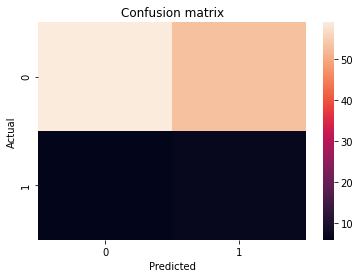

In [42]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()

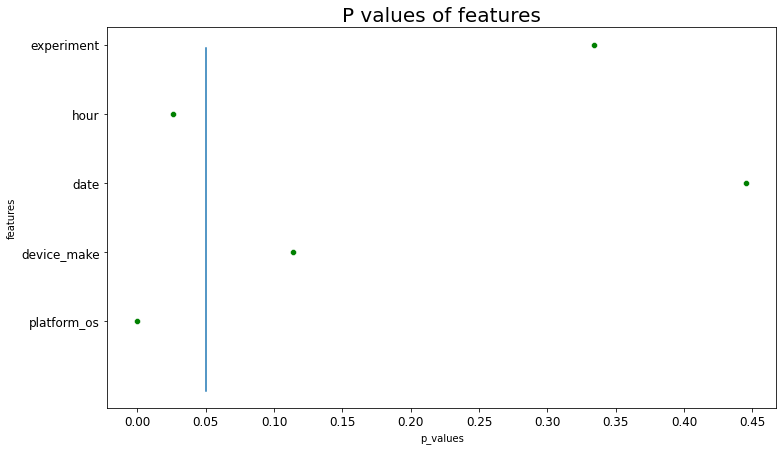

,features,p_values
0,experiment,3.340825e-01
1,hour,2.637949e-02
2,date,4.452749e-01
3,device_make,1.137725e-01
4,platform_os,4.231657e-87


In [43]:
p_values_df = logesticRegressionModel.get_p_values()
p_value_fig = logesticRegressionModel.plot_pvalues(p_values_df)
p_values_df

In [44]:
class XGBClassifierModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, max_depth=5):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.clf = GradientBoostingClassifier()

        
    def train(self, folds=1):
        
        kf = KFold(n_splits = folds)
        
        iterator = kf.split(self.X_train)
        
        loss_arr = []
        acc_arr = []
        for i in range(folds):
            train_index, valid_index = next(iterator)
            
            X_train, y_train = self.X_train.iloc[train_index], self.y_train.iloc[train_index]
            X_valid, y_valid = self.X_train.iloc[valid_index], self.y_train.iloc[valid_index]
                        
            self.clf = self.clf.fit(X_train, y_train)
            
            vali_pred = self.clf.predict(X_valid)
            
            accuracy = self.calculate_score(y_valid
                                              , vali_pred)
            
            loss = loss_function(y_valid, vali_pred)
            
            self.__printAccuracy(accuracy, i, label="Validation")
            self.__printLoss(loss, i, label="Validation")
            print()
            
            acc_arr.append(accuracy)
            loss_arr.append(loss)

            
        return self.clf, acc_arr, loss_arr
    
    def test(self):
        
        y_pred = self.clf.predict(self.X_test)
        
        accuracy = self.calculate_score(y_pred, self.y_test)
        self.__printAccuracy(accuracy, label="Test")
        
        report = self.report(y_pred, self.y_test)
        matrix = self.confusion_matrix(y_pred, self.y_test)
        
        loss = loss_function(self.y_test, y_pred)
        
        return accuracy, loss,  report, matrix
    
    def get_feature_importance(self):
        importance = self.clf.feature_importances_
        fi_df = pd.DataFrame()
        
        fi_df['feature'] = self.X_train.columns.to_list()
        fi_df['feature_importances'] = importance
        
        return fi_df
    
    def __printAccuracy(self, acc, step=1, label=""):
        print(f"step {step}: {label} Accuracy of DecisionTreesModel is: {acc:.3f}")
    
    def __printLoss(self, loss, step=1, label=""):
        print(f"step {step}: {label} Loss of DecisionTreesModel is: {loss:.3f}")
    
    def calculate_score(self, pred, actual):
        return metrics.accuracy_score(actual, pred)
    
    def report(self, pred, actual):
        print("Test Metrics")
        print("================")
        print(metrics.classification_report(pred, actual))
        return metrics.classification_report(pred, actual)
    
    def confusion_matrix(self, pred, actual):
        ax=sns.heatmap(pd.DataFrame(metrics.confusion_matrix(pred, actual)))
        plt.title('Confusion matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        return metrics.confusion_matrix(pred, actual)


        
    
    
    


In [58]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [59]:
xGBClassifierModel = XGBClassifierModel(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = xGBClassifierModel.train(folds)

write_model('platform_os_XGBoost_model', clf3)

2021/07/24 22:08:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '19e390e3737b4c7bac9f2c425ded1f1c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


step 0: Validation Accuracy of DecisionTreesModel is: 0.562
step 0: Validation Loss of DecisionTreesModel is: 0.661



2021/07/24 22:08:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '90882e2c79e94c3196171bf25667a88d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


step 1: Validation Accuracy of DecisionTreesModel is: 0.522
step 1: Validation Loss of DecisionTreesModel is: 0.691



2021/07/24 22:08:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1547c90a211d46d1a732ef40b733ac15', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


step 2: Validation Accuracy of DecisionTreesModel is: 0.545
step 2: Validation Loss of DecisionTreesModel is: 0.675



2021/07/24 22:08:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4204bd70dfaf4e748e4f1728a7c43f31', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


step 3: Validation Accuracy of DecisionTreesModel is: 0.543
step 3: Validation Loss of DecisionTreesModel is: 0.676



2021/07/24 22:08:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fb1f602b05244ce7a2d7af92a425dfef', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


step 4: Validation Accuracy of DecisionTreesModel is: 0.525
step 4: Validation Loss of DecisionTreesModel is: 0.689



step 1: Test Accuracy of DecisionTreesModel is: 0.584
Test Metrics
              precision    recall  f1-score   support

           0       0.78      0.57      0.66        89
           1       0.37      0.61      0.46        36

    accuracy                           0.58       125
   macro avg       0.58      0.59      0.56       125
weighted avg       0.66      0.58      0.60       125

Loss on test data is: 0.645



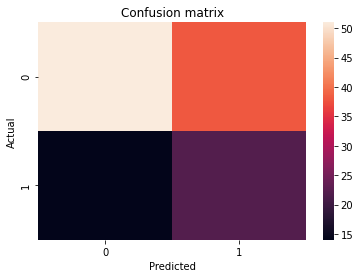

In [60]:
test_acc, loss, report, confusion_matrix = xGBClassifierModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [61]:
xGBClassifierModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.081586
1,hour,0.205152
2,date,0.115274
3,device_make,0.508903
4,browser,0.089086


### Hyper Paramter tuning for Decision Tree

In [48]:
from sklearn.model_selection import GridSearchCV

params = {'criterion': ['gini','entropy'], 'max_depth':[4,5,6,7,8,9,10]}

kfold = KFold(n_splits=5)
gridSearch = GridSearchCV(estimator=clf, param_grid=params, n_jobs=-1,  cv=kfold, scoring="neg_root_mean_squared_error")


import mlflow
import datetime
Current_Date = datetime.datetime.today()

mlflow.set_experiment('DecisionTree-' + str(Current_Date))
mlflow.sklearn.autolog()
with mlflow.start_run(run_name='DT-Hyperparameter') as run:
        searchResults = gridSearch.fit(X_train, y_train)
        
        pred=searchResults.predict(X_test)
        loss=loss_function(y_test,pred)
        acc = metrics.accuracy_score(y_test, pred)
        
        mlflow.log_param('Features', X_train.columns.to_list())
        mlflow.log_param('Target', y_train.columns.to_list())
        mlflow.log_param('Number Of Training Dataset', X_train.shape[0])
        mlflow.log_param('Number Of Test Dataset', X_test.shape[0])
        mlflow.log_param('Fold number', folds)
                      
        

        mlflow.log_metric("loss", loss)
        mlflow.log_metric("accuracy", acc)



best_dt_Model = searchResults.best_estimator_

INFO: 'DecisionTree-2021-07-24 21:49:30.499356' does not exist. Creating a new experiment


2021/07/24 21:49:36 INFO mlflow.sklearn.utils: Logging the 5 best runs, 9 runs will be omitted.


### Hyper Paramter tuning for LR

In [49]:
from sklearn.model_selection import GridSearchCV

params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
kfold = KFold(n_splits=5)

mlflow.sklearn.autolog()
gridSearch = GridSearchCV(estimator=clf2, param_grid=params, n_jobs=-1,  cv=kfold, scoring="neg_root_mean_squared_error")

mlflow.set_experiment('LogisticRegression-' + str(Current_Date))
with mlflow.start_run(run_name='LR-Hyperparameter') as run:
        searchResults = gridSearch.fit(X_train, y_train)
        
        pred=searchResults.predict(X_test)
        loss=loss_function(y_test,pred)
        acc = metrics.accuracy_score(y_test, pred)
        
        mlflow.log_param('Features', X_train.columns.to_list())
        mlflow.log_param('Target', y_train.columns.to_list())
        mlflow.log_param('Number Of Training Dataset', X_train.shape[0])
        mlflow.log_param('Number Of Test Dataset', X_test.shape[0])
        mlflow.log_param('Fold number', folds)

        mlflow.log_metric("loss", loss)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_figure(p_value_fig, 'p_values.png')



best_lr_model = searchResults.best_estimator_

INFO: 'LogisticRegression-2021-07-24 21:49:30.499356' does not exist. Creating a new experiment


2021/07/24 21:50:20 INFO mlflow.sklearn.utils: Logging the 5 best runs, 9 runs will be omitted.


In [55]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [20, 40, 60, 80]}

kfold = KFold(n_splits=5)
gridSearch = GridSearchCV(estimator=clf3, param_grid=params, n_jobs=-1,  cv=kfold, scoring="neg_root_mean_squared_error")


import mlflow
import datetime
Current_Date = datetime.datetime.today()

mlflow.set_experiment('XGBoost-' + str(Current_Date))
mlflow.sklearn.autolog()
with mlflow.start_run(run_name='XGBoost-Hyperparameter') as run:
        searchResults = gridSearch.fit(X_train, y_train)
        
        pred=searchResults.predict(X_test)
        loss=loss_function(y_test,pred)
        acc = metrics.accuracy_score(y_test, pred)
        
        mlflow.log_param('Features', X_train.columns.to_list())
        mlflow.log_param('Target', y_train.columns.to_list())
        mlflow.log_param('Number Of Training Dataset', X_train.shape[0])
        mlflow.log_param('Number Of Test Dataset', X_test.shape[0])
        mlflow.log_param('Fold number', folds)
                      
        

        mlflow.log_metric("loss", loss)
        mlflow.log_metric("accuracy", acc)



best_dt_Model = searchResults.best_estimator_

INFO: 'XGBoost-2021-07-24 22:01:17.349064' does not exist. Creating a new experiment


2021/07/24 22:01:22 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
